### 句子情感分类 - 判断社交网络中的句子的情感倾向
#### Data Download: https://www.lintcode.com/ai/UMICH_Sentiment_Analysis/data

        

In [27]:
import numpy as np
import collections
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os
import nltk
from keras.preprocessing import sequence
import tqdm
%matplotlib inline

In [7]:
DATA_DIR = "./data"

train_data = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_data = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

train_data.head()

,sentence,label
0,Ok brokeback mountain is such a horrible movie.,0
1,Brokeback Mountain was so awesome.,1
2,friday hung out with kelsie and we went and sa...,0
3,I am going to start reading the Harry Potter s...,1
4,"Is it just me, or does Harry Potter suck?...",0


In [8]:
test_data.head()

,sentence
0,"I liked the first "" Mission Impossible."
1,I love Harry Potter..
2,"Not because I hate Harry Potter, but because I..."
3,the story of Harry Potter is a deep and profou...
4,"The complaints I've seen about the "" Vito-bein..."


In [9]:
num_recs = len(train_data) # number of total train sentences
print(num_recs)

5668


In [22]:
len(test_data) # number of total test sentences

1418

In [36]:
train_data_10 = train_data.head(1)
test_data_10 = test_data.head(1)

In [40]:
nltk.download('punkt') #

[nltk_data] Downloading package punkt to /Users/s4467575/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [65]:
maxlen = 0 # maximum sentence length
word_freqs = collections.Counter() # word frequency

# Note: train， test 数据都要考虑到
for data in [train_data, test_data]: # 相当于把train test 一起同时处理了，否则需要两个for loop分别处理train 和test
    for index, row in data.iterrows(): # iterae each row
        '''
            为了使用nltk.word_tokenize, 需要先run "nltk.download('punkt')" command to download 语料库
            nltk.word_tokenize就是把句子分割成单词：
            e.g. "Ok brokeback mountain is such a horrible movie." ==>
                  ['ok', 'brokeback', 'mountain', 'is', 'such', 'a', 'horrible', 'movie', '.']
            
            因为train  data 里的 有lable column, 所以row['sentence'] 表示只处理"sentence" column
            
        '''
        words = nltk.word_tokenize(row['sentence'].lower())
        if (len(words) > maxlen):
            maxlen = len(words)
        for word in words:
            word_freqs[word] += 1

# word_freqs: dict type: (word, counts)

In [66]:
print(len(word_freqs))
print(maxlen)

2328
42


In [67]:
MAX_FEATURES = 2300 # number of unique words
MAX_SENTENCE_LENGTH = maxlen # maximum sentence length

In [76]:
vocab_size = MAX_FEATURES + 2 # two more extra special words "PAD", "UNK"

"""
    i: index, x: ('i', 4705), x[0]: i (即表示实际的word)
    本来 i就是表示index的意思， 只不过 0， 1 预留给了PAD, UNK特殊字符，其他所有的word的index都往后顺移2位
"""
word2index = {x[0]: i+2 for i, x in enumerate(word_freqs.most_common(MAX_FEATURES))} # word2index: (word, index), from most to least
# word_freqs: (word, count)

word2index["PAD"] = 0
word2index["UNK"] = 1

index2word = {v:k for k, v in word2index.items()} # word2index: (index, word), from most to least


In [ ]:
print(word2index)

In [77]:
data_X = np.empty((num_recs, ), dtype=list) # num_recs: number of total train sentences
data_y = np.zeros((num_recs, ))

#把train_data 每一句话 都split 成word,让后把word -> 对应的index
for i, (index, row) in enumerate(train_data.iterrows()):
    words = nltk.word_tokenize(row['sentence'].lower())
    seqs = []
    for word in words:
        seqs.append(word2index.get(word, word2index['UNK']))
    data_X[i] = seqs
    data_y[i] = int(row['label'])

In [79]:
# padding  把train_data里长度不一样的句子padding成一样长的，以最长的句子为标准， 不够长的在末尾补<PAD>
data_X_in = sequence.pad_sequences(data_X, padding='post', value=word2index['PAD'], maxlen=MAX_SENTENCE_LENGTH)
print(data_X_in[:3])
print(data_X_in.shape)

[[ 94  11  13  17 143  18 126  26   4   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [ 11  13  19  33  22   4   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [166 228  53  47 229   6  44 108   6 114   5  10   9  12  32   7   7   7
    7   7   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]]
(5668, 42)


In [80]:
pd.Series(data_y).value_counts() / len(data_y)  # 数据平衡

1.0    0.565279
0.0    0.434721
dtype: float64

In [81]:
def data_generator(batch_size):
    while True:
        for i in range(0, len(data_X_in), batch_size):
            if i + batch_size < len(data_X_in):
                # [len(i) for i in data_X[i:i + batch_size]] 每个句子实际长度
                yield data_X_in[i:i + batch_size], data_y[i:i + batch_size], [len(i) for i in data_X[i:i + batch_size]]

## Model Part - 可参考text_classify_basic 因为任务性质差不多，都是分类

In [95]:
batch_size = 100
embedding_size = 16 # 就是词的embedding table 的列数， 也就是每个单词就会变成 1 * 100 的矩阵
vocab_size = MAX_FEATURES + 2
num_units = 16
NUM_EPOCHS = 16
"""
    num_units = 16 Hyper parameter. 是隐变量c的维度. 也就是每个RNN cell 的输出维度
    Note: 
        RNN NMT 结构中，左边endocer公用一个RNN(虽然结构图里画了3个box,其实就是一个共享权重的RNN)，同理右半边decoder网络也是。
        但是左边 和右边 的两个RNN 并不共享网络权重参数

    在text_classfify任务的的时候，老师课上解释： RNN->S1->RNN->S2...这里的16就是就是S1的大小，也就是hidden unit memory 的大小
    16个float -> 50 * 32bit (i.e. 50 * 4字节)
   
    在LSTM里：相当于Ct(长期记忆)和Ht（短期记忆）都是num_unit个浮点数， 也就是memory size. 在标准的RNN里就是是S1, S2 等这些状态的memeory size. 

"""
losses = []
beginning_lr = 0.1
gen = data_generator(batch_size)




In [96]:
import tensorflow as tf
tf.reset_default_graph()
"""
    allow_soft_placement=True, config.gpu_options.allow_growth = True
    上面两句作用：可以动态分配GPU
"""
config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)

In [97]:
tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True, allow_soft_placement = True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)

with tf.device('/gpu:0'): # gpu:0表示gpu编号
    # 下面几行初始化后变量和 seq2seq_basic 里类似
    initializer = tf.random_uniform_initializer(-0.08, 0.08)
    tf.get_variable_scope().set_initializer(initializer)
    x = tf.placeholder("int32", [None, None])
    y = tf.placeholder("int32", [None])
    x_len = tf.placeholder("int32", [None])
    
    learning_rate = tf.placeholder(tf.float32, shape=[])
    
    # embedding 和 text_classify_basic 里写法类似
    # tf.get_variable("embedding_encoder") 如果变量存在， 直接使用，如果没有该变量，就重新生成一个变量
    embedding_encoder = tf.get_variable("embedding_encoder", [vocab_size, embedding_size], dtype=tf.float32)
    encoder_emb_inp = tf.nn.embedding_lookup(embedding_encoder, x)
    
    # Build RNN cell
    encoder_cell = tf.contrib.rnn.BasicLSTMCell(num_units)
    
    encoder_cell = tf.contrib.rnn.DropoutWrapper(cell=encoder_cell, output_keep_prob=0.5)
    # Run Dynamic RNN
    #   encoder_outputs: [max_time, batch_size, num_units]
    #   encoder_state: [batch_size, num_units]
    encoder_outputs, encoder_state = tf.nn.dynamic_rnn(
        encoder_cell, encoder_emb_inp,
        sequence_length=x_len, time_major=False, dtype=tf.float32) 
        #x_len 是反应每个句子实际的长度（padding之前的），也就是data_generator返回的最后一个参数
        # encoder_outputs 对应RNN网络右边top的每个输出
    model_logistic = tf.layers.dense(encoder_state[0], 1)  # encoder_state[0] c 也就是长期记忆，    encoder_state[1] h
    model_pred = tf.nn.sigmoid(model_logistic)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(y, tf.float32), logits=tf.reshape(model_logistic,(-1,)))
    loss = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(loss)
    
session.run(tf.global_variables_initializer())

## Training Part

In [98]:
for one_epoch in tqdm.trange(0, NUM_EPOCHS, desc='outer_epoch'):
    for one_batch in tqdm.tqdm(range(0, len(data_X_in) ,batch_size), total=len(data_X_in) // batch_size):
        batch_x, batch_y, batch_x_len = gen.__next__() # batch_x_len batch里 每个句子长度
        batch_lr = beginning_lr 
        
        _, batch_loss = session.run([optimizer, loss], feed_dict={
            x: batch_x,
            y: batch_y,
            x_len: batch_x_len,
            learning_rate: batch_lr,
        })
        losses.append(batch_loss)

 86%|████████▌ | 48/56 [00:00<00:00, 20.65it/s]
57it [00:00, 26.81it/s]                        
 86%|████████▌ | 48/56 [00:00<00:00, 78.34it/s]
57it [00:00, 79.43it/s]                        
 88%|████████▊ | 49/56 [00:00<00:00, 76.36it/s]
57it [00:00, 76.70it/s]                        
outer_epoch: 100%|██████████| 16/16 [00:11<00:00,  1.33it/s]


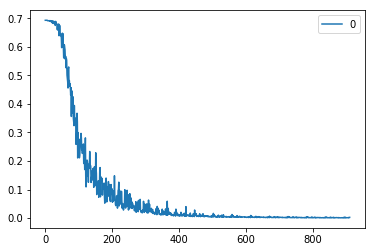

In [99]:
pd.DataFrame(losses).plot()

## run predict 

In [100]:
test_recs = len(test_data)
print(test_recs)

1418


In [101]:
test_X = []

for index, row in test_data.iterrows():
    words = nltk.word_tokenize(row['sentence'].lower()) # 每一行的 sentence column 里的句子分割成词
    senttoken = [word2index.get(word, word2index['UNK']) for word in words]
    test_X.append(senttoken)

# test_X = sequence.pad_sequences(test_X, padding='post', value=word2index['PAD'], maxlen=MAX_SENTENCE_LENGTH)

In [106]:
test_X[:2]

[[2, 122, 5, 115, 36, 20, 21, 4], [2, 16, 8, 50]]

In [112]:
def predict_result(senttoken):
    inputx = np.asarray([senttoken])
    inputx_len = np.asarray([len(senttoken)])
    return session.run(model_pred, feed_dict={
            x:inputx,
            x_len:inputx_len,
        })[0]

logits = []
for row in test_X:
    logits.append(predict_result(row))
    
logits = pd.Series(logits)

In [113]:
logits[:3]

0        [0.9999784]
1       [0.99853027]
2    [1.6598815e-05]
dtype: object

In [114]:
# n_percent = (pd.Series(data_y).value_counts() / len(data_y))[0]
# n_num = int(n_percent * len(logits))
# logits[logits.sort_values().index[:n_num]] = 0
# logits[logits.sort_values().index[n_num:]] = 1

logits = (logits > 0.5).astype('int')

In [115]:
logits[:3]

0    1
1    1
2    0
dtype: int64

In [118]:
COLUMN_NAMES = ['sentence', 'label']
df = pd.DataFrame(columns=COLUMN_NAMES)

df['sentence'] = test_data['sentence']
ll = pd.Series(logits)
df['label'] = ll.values
print(df.shape)

(1418, 2)


In [119]:
print(df.head())

                                            sentence  label
0            I liked the first " Mission Impossible.      1
1                              I love Harry Potter..      1
2  Not because I hate Harry Potter, but because I...      0
3  the story of Harry Potter is a deep and profou...      1
4  The complaints I've seen about the " Vito-bein...      0


In [122]:
df.to_csv(os.path.join(DATA_DIR, "submission.csv"), index=False)

In [124]:
y_test = pd.read_csv(os.path.join(DATA_DIR, "submission.csv")) # 正确答案
print(y_test.head())

                                            sentence  label
0            I liked the first " Mission Impossible.      1
1                              I love Harry Potter..      1
2  Not because I hate Harry Potter, but because I...      0
3  the story of Harry Potter is a deep and profou...      1
4  The complaints I've seen about the " Vito-bein...      0
